# Data and packages imports

In [1]:
import keras
from keras import layers
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image_dataset_from_directory
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import os, shutil
from keras import regularizers
from sklearn import metrics
import seaborn as sns
import numpy
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Settings

In [3]:
patience = 7
size = 256
seed = 5

# Data pre processing


In [4]:
#Augmentation
train_datagen = ImageDataGenerator(
            rescale = 1./255,
            rotation_range = 40,
            width_shift_range = 0.2,
            height_shift_range = 0.2,
            shear_range = 0.2,
            zoom_range = 0.2,
            horizontal_flip = True,
            fill_mode = 'nearest')

val_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
                    'drive/MyDrive/project_data_V1/train',
                    target_size = (size, size),
                    batch_size = 32,
                  class_mode = 'categorical',
                  seed = seed)

validation_generator = val_datagen.flow_from_directory(
                    'drive/MyDrive/project_data_V1/val',
                    target_size = (size, size),
                    batch_size = 32,
                    class_mode = 'categorical',
                    shuffle = False,
                    seed = seed)

test_data_generator = test_generator.flow_from_directory(
                    'drive/MyDrive/project_data_V1/test', 
                     target_size=(size, size),
                     batch_size=32,
                     shuffle=False,
                     seed = seed)

Found 5314 images belonging to 10 classes.
Found 1269 images belonging to 10 classes.
Found 34 images belonging to 10 classes.


In [5]:
# import os
# import cv2
# bad_list=[]
# dir=r'drive/MyDrive/project_data_V1'
# subdir_list=os.listdir(dir) # create a list of the sub directories in the directory ie train or test
# for d in subdir_list:  # iterate through the sub directories train and test
#     dpath=os.path.join (dir, d) # create path to sub directory
#     if d in ['val']:
#         class_list=os.listdir(dpath) # list of classes ie dog or cat
#        # print (class_list)
#         for klass in class_list: # iterate through the two classes
#             class_path=os.path.join(dpath, klass) # path to class directory
#             #print(class_path)
#             file_list=os.listdir(class_path) # create list of files in class directory
#             for f in file_list: # iterate through the files
#                 fpath=os.path.join (class_path,f)
#                 index=f.rfind('.') # find index of period infilename
#                 ext=f[index+1:] # get the files extension
#                 if ext  not in ['jpg', 'png', 'bmp', 'gif']:
#                     print(f'file {fpath}  has an invalid extension {ext}')
#                     bad_list.append(fpath)                    
#                 else:
#                     try:
#                         img=cv2.imread(fpath)
#                         size=img.shape
#                     except:
#                         print(f'file {fpath} is not a valid image file ')
#                         bad_list.append(fpath)
                       
# print(bad_list)             

In [6]:
# len(bad_list)

In [7]:
# for file_ in bad_list:
#   os.remove(file_)

In [8]:
pd.Series(train_generator.classes).value_counts()

5    785
1    768
2    736
7    699
6    675
4    649
3    311
0    265
9    237
8    189
dtype: int64

# Re-sorting data

In [9]:
# os.mkdir(os.path.join('drive', 'MyDrive','project_data_V1','train_bal'))

# for genre in os.listdir(os.path.join('drive', 'MyDrive','project_data_V1','train')):

#   os.mkdir(os.path.join('drive', 'MyDrive','project_data_V1','train_bal', genre))
#   paintings = os.listdir(os.path.join('drive', 'MyDrive','project_data_V1','train', genre))

#   for painting in paintings[:189]:

#     src = os.path.join('drive', 'MyDrive','project_data_V1','train', genre, painting)
#     dst = os.path.join('drive', 'MyDrive','project_data_V1','train_bal', genre, painting)
#     shutil.copyfile(src, dst)

In [10]:
train_bal_datagen = ImageDataGenerator(
            rescale = 1./255,
            rotation_range = 40,
            width_shift_range = 0.2,
            height_shift_range = 0.2,
            shear_range = 0.2,
            zoom_range = 0.2,
            horizontal_flip = True,
            fill_mode = 'nearest')

train_bal_generator = train_datagen.flow_from_directory(
                    'drive/MyDrive/project_data_V1/train_bal',
                    target_size = (size, size),
                    batch_size = 32,
                    class_mode = 'binary',
                    seed = seed)

Found 1890 images belonging to 10 classes.


# Functions

In [11]:
def plot_train_val_loss(history_dict, epochs):
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    epochs = epochs

    plt.plot(epochs, loss_values, 'bo', label = 'Training Loss')
    plt.plot(epochs, val_loss_values, 'b', label = 'Validation Loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [12]:
def plot_train_val_acc(history_dict, epochs):
    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']
    
    epochs = epochs
    
    plt.plot(epochs, acc_values, 'bo', label = 'Training acc')
    plt.plot(epochs, val_acc_values, 'b', label = 'Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [13]:
def confusion_matrix_report(model, test = test_data_generator):
  test_steps_per_epoch = numpy.math.ceil(test.samples / test.batch_size)
  predictions = model.predict(test, steps=test_steps_per_epoch)
  predicted_classes = numpy.argmax(predictions, axis=1)
  true_classes = test.classes
  class_labels = list(test.class_indices.keys())
  report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
  cf = metrics.confusion_matrix(true_classes, predicted_classes)
  sns.heatmap(cf, annot=True, xticklabels=class_labels, yticklabels=class_labels)
  plt.show()
  print(report)

# Model 1



In [ ]:
model = models.Sequential()

model = models.Sequential()

model.add(layers.Conv2D(96, (3,3), activation = 'relu',
                       input_shape= (256, 256, 3)))
model.add(layers.Conv2D(96, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(192, (3,3), activation = 'relu'))
model.add(layers.Conv2D(192, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(384, (3,3), activation = 'relu'))
model.add(layers.Conv2D(384, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.2))

model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(10, activation = 'softmax'))

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 254, 254, 96)      2688      
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 252, 252, 96)      83040     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 126, 126, 96)      0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 124, 124, 192)     166080    
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 122, 122, 192)     331968    
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 61, 61, 192)       0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 59, 59, 384)     

In [ ]:
opti = keras.optimizers.RMSprop(momentum=0.1) 
loss = 'categorical_crossentropy' #keras.losses.SparseCategoricalCrossentropy(from_logits=True)  
metr = ['accuracy']

model.compile(optimizer = opti, 
              loss = loss, 
              metrics = metr)

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss',
                              patience = patience)

history = model.fit( 
            train_generator,
            epochs = 100,
            validation_data = validation_generator,
            # verbose = False
            callbacks = [early_stopping]
            )

Epoch 1/100
167/167 [==============================] - 147s 878ms/step - loss: 2.4700 - accuracy: 0.1284 - val_loss: 2.0351 - val_accuracy: 0.1907
Epoch 2/100
167/167 [==============================] - 146s 873ms/step - loss: 2.0456 - accuracy: 0.2031 - val_loss: 1.9405 - val_accuracy: 0.2522
Epoch 3/100
167/167 [==============================] - 147s 876ms/step - loss: 1.9501 - accuracy: 0.2447 - val_loss: 1.8297 - val_accuracy: 0.2774
Epoch 4/100
167/167 [==============================] - 147s 878ms/step - loss: 1.8808 - accuracy: 0.2661 - val_loss: 1.8678 - val_accuracy: 0.2955
Epoch 5/100
167/167 [==============================] - 147s 877ms/step - loss: 1.8478 - accuracy: 0.2769 - val_loss: 1.8648 - val_accuracy: 0.2797
Epoch 6/100
167/167 [==============================] - 147s 878ms/step - loss: 1.8252 - accuracy: 0.2809 - val_loss: 1.7570 - val_accuracy: 0.3270
Epoch 7/100
167/167 [==============================] - 146s 875ms/step - loss: 1.8355 - accuracy: 0.2865 - val_loss: 1

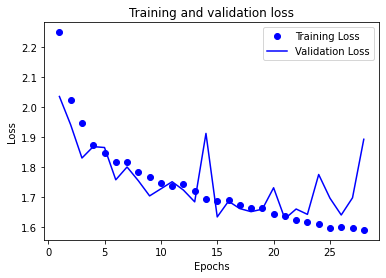

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['accuracy']) + 1)
plot_train_val_loss(history_dict, epochs)

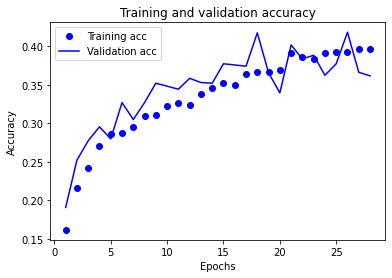

In [ ]:
plot_train_val_acc(history_dict, epochs)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


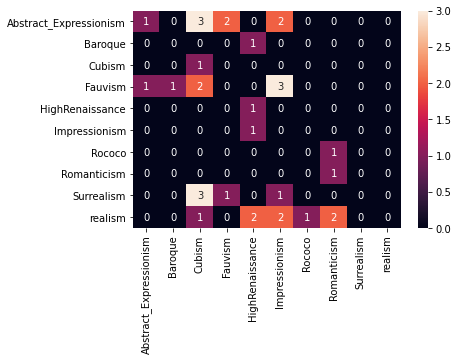

                        precision    recall  f1-score   support

Abstract_Expressionism       0.50      0.12      0.20         8
               Baroque       0.00      0.00      0.00         1
                Cubism       0.10      1.00      0.18         1
               Fauvism       0.00      0.00      0.00         7
       HighRenaissance       0.20      1.00      0.33         1
         Impressionism       0.00      0.00      0.00         1
                Rococo       0.00      0.00      0.00         1
           Romanticism       0.25      1.00      0.40         1
            Surrealism       0.00      0.00      0.00         5
               realism       0.00      0.00      0.00         8

              accuracy                           0.12        34
             macro avg       0.11      0.31      0.11        34
          weighted avg       0.13      0.12      0.07        34



In [ ]:
confusion_matrix_report(model)

# Model 2



In [ ]:
model = models.Sequential()

model = models.Sequential()

model.add(layers.Conv2D(96, (3,3), activation = 'relu',
                       input_shape= (256, 256, 3)))
model.add(layers.Conv2D(96, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(192, (3,3), activation = 'relu'))
model.add(layers.Conv2D(192, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(384, (3,3), activation = 'relu'))
model.add(layers.Conv2D(384, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.2))

model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(10, activation = 'softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 254, 254, 96)      2688      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 252, 252, 96)      83040     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 126, 126, 96)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 124, 124, 192)     166080    
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 122, 122, 192)     331968    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 61, 61, 192)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 59, 59, 384)      

In [ ]:
opti = keras.optimizers.RMSprop(momentum=0.1) 
loss = 'categorical_crossentropy' #keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
metr = ['accuracy']

model.compile(optimizer = opti, 
              loss = loss, 
              metrics = metr)

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss',
                              patience = patience)

history = model.fit( 
            train_generator,
            epochs = 100,
            validation_data = validation_generator,
            # verbose = False
            callbacks = [early_stopping]
            )
model.save('drive/MyDrive/models/cnn_model2.h5')

Epoch 1/100
167/167 [==============================] - 134s 803ms/step - loss: 2.5820 - accuracy: 0.1474 - val_loss: 2.1136 - val_accuracy: 0.1931
Epoch 2/100
167/167 [==============================] - 133s 797ms/step - loss: 2.0741 - accuracy: 0.2074 - val_loss: 1.8370 - val_accuracy: 0.2853
Epoch 3/100
167/167 [==============================] - 132s 789ms/step - loss: 1.9568 - accuracy: 0.2508 - val_loss: 1.8289 - val_accuracy: 0.2648
Epoch 4/100
167/167 [==============================] - 132s 790ms/step - loss: 1.8523 - accuracy: 0.2855 - val_loss: 1.8388 - val_accuracy: 0.2608
Epoch 5/100
167/167 [==============================] - 132s 788ms/step - loss: 1.8499 - accuracy: 0.2819 - val_loss: 1.7739 - val_accuracy: 0.3081
Epoch 6/100
167/167 [==============================] - 132s 790ms/step - loss: 1.8027 - accuracy: 0.2972 - val_loss: 1.7852 - val_accuracy: 0.2979
Epoch 7/100
167/167 [==============================] - 132s 790ms/step - loss: 1.7743 - accuracy: 0.3170 - val_loss: 1

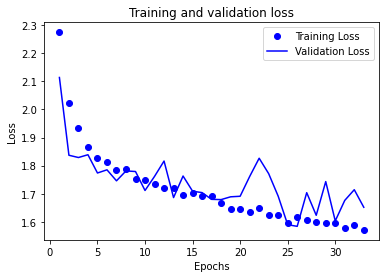

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['accuracy']) + 1)
plot_train_val_loss(history_dict, epochs)

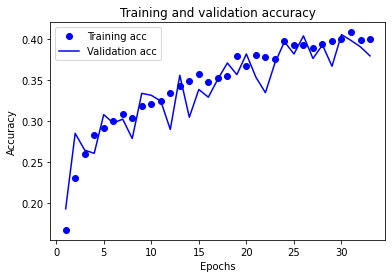

In [ ]:
plot_train_val_acc(history_dict, epochs)

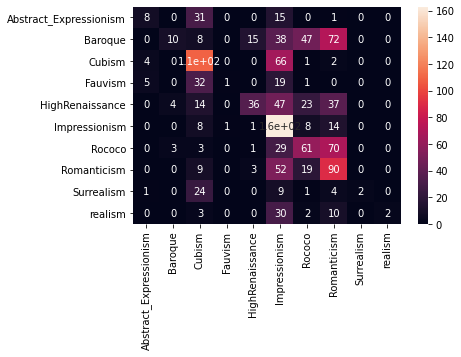

                        precision    recall  f1-score   support

Abstract_Expressionism       0.44      0.15      0.22        55
               Baroque       0.59      0.05      0.10       190
                Cubism       0.45      0.60      0.52       182
               Fauvism       0.50      0.02      0.03        58
       HighRenaissance       0.64      0.22      0.33       161
         Impressionism       0.35      0.84      0.49       195
                Rococo       0.37      0.37      0.37       167
           Romanticism       0.30      0.52      0.38       173
            Surrealism       1.00      0.05      0.09        41
               realism       1.00      0.04      0.08        47

              accuracy                           0.38      1269
             macro avg       0.57      0.29      0.26      1269
          weighted avg       0.49      0.38      0.32      1269



In [ ]:
confusion_matrix_report(model, test = validation_generator)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


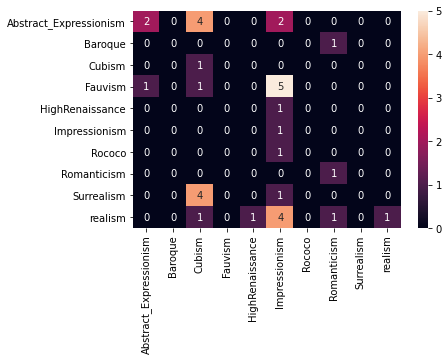

                        precision    recall  f1-score   support

Abstract_Expressionism       0.67      0.25      0.36         8
               Baroque       0.00      0.00      0.00         1
                Cubism       0.09      1.00      0.17         1
               Fauvism       0.00      0.00      0.00         7
       HighRenaissance       0.00      0.00      0.00         1
         Impressionism       0.07      1.00      0.12         1
                Rococo       0.00      0.00      0.00         1
           Romanticism       0.33      1.00      0.50         1
            Surrealism       0.00      0.00      0.00         5
               realism       1.00      0.12      0.22         8

              accuracy                           0.18        34
             macro avg       0.22      0.34      0.14        34
          weighted avg       0.41      0.18      0.16        34



In [ ]:
confusion_matrix_report(model)

# Model 3



In [ ]:
model = models.Sequential()

model = models.Sequential()

model.add(layers.Conv2D(96, (3,3), activation = 'relu',
                       input_shape= (256, 256, 3)))
model.add(layers.Conv2D(96, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(192, (3,3), activation = 'relu'))
model.add(layers.Conv2D(192, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(384, (3,3), activation = 'relu'))
model.add(layers.Conv2D(384, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(384, (3,3), activation = 'relu'))
model.add(layers.Conv2D(384, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.2))

model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(10, activation = 'softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 96)      2688      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 96)      83040     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 96)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 192)     166080    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 122, 122, 192)     331968    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 192)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 59, 59, 384)      

In [ ]:
opti = keras.optimizers.RMSprop(momentum=0.1) 
loss = 'categorical_crossentropy' #keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
metr = ['accuracy']

model.compile(optimizer = opti, 
              loss = loss, 
              metrics = metr)

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss',
                              patience = patience)

history = model.fit( 
            train_generator,
            epochs = 100,
            validation_data = validation_generator,
            # verbose = False,
            callbacks = [early_stopping]
            )
model.save('drive/MyDrive/models/cnn_model3.h5')

Epoch 1/100
167/167 [==============================] - 5530s 33s/step - loss: 2.2729 - accuracy: 0.1465 - val_loss: 2.1677 - val_accuracy: 0.1497
Epoch 2/100
167/167 [==============================] - 237s 1s/step - loss: 2.1950 - accuracy: 0.1407 - val_loss: 2.1765 - val_accuracy: 0.1363
Epoch 3/100
167/167 [==============================] - 237s 1s/step - loss: 2.2090 - accuracy: 0.1389 - val_loss: 2.1641 - val_accuracy: 0.1537
Epoch 4/100
167/167 [==============================] - 237s 1s/step - loss: 2.2015 - accuracy: 0.1457 - val_loss: 2.1765 - val_accuracy: 0.1537
Epoch 5/100
167/167 [==============================] - 237s 1s/step - loss: 2.2008 - accuracy: 0.1363 - val_loss: 2.1672 - val_accuracy: 0.1537
Epoch 6/100
167/167 [==============================] - 237s 1s/step - loss: 2.2052 - accuracy: 0.1552 - val_loss: 2.1632 - val_accuracy: 0.1363
Epoch 7/100
167/167 [==============================] - 237s 1s/step - loss: 2.1991 - accuracy: 0.1361 - val_loss: 2.1696 - val_accurac

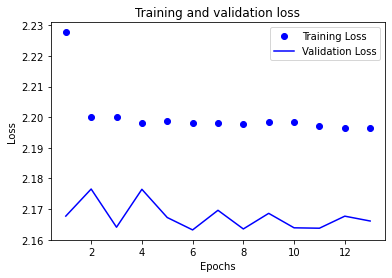

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['accuracy']) + 1)
plot_train_val_loss(history_dict, epochs)

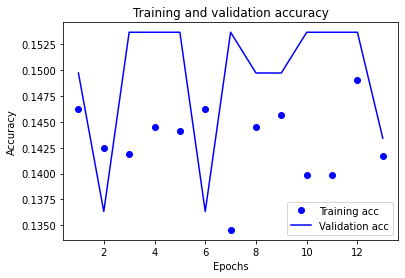

In [ ]:
plot_train_val_acc(history_dict, epochs)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


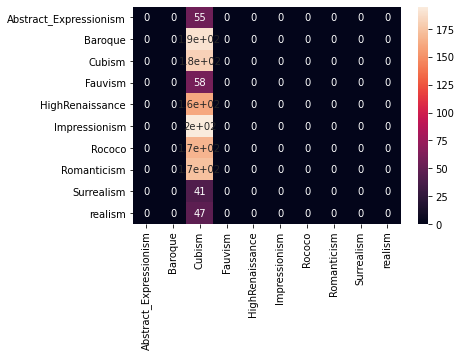

                        precision    recall  f1-score   support

Abstract_Expressionism       0.00      0.00      0.00        55
               Baroque       0.00      0.00      0.00       190
                Cubism       0.14      1.00      0.25       182
               Fauvism       0.00      0.00      0.00        58
       HighRenaissance       0.00      0.00      0.00       161
         Impressionism       0.00      0.00      0.00       195
                Rococo       0.00      0.00      0.00       167
           Romanticism       0.00      0.00      0.00       173
            Surrealism       0.00      0.00      0.00        41
               realism       0.00      0.00      0.00        47

              accuracy                           0.14      1269
             macro avg       0.01      0.10      0.03      1269
          weighted avg       0.02      0.14      0.04      1269



In [ ]:
confusion_matrix_report(model, test = validation_generator)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


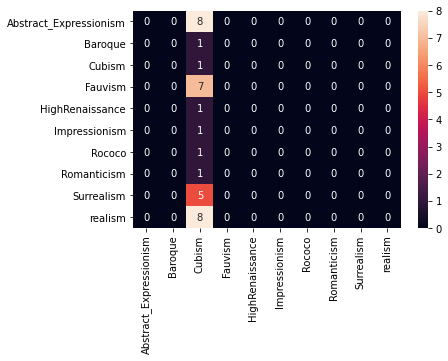

                        precision    recall  f1-score   support

Abstract_Expressionism       0.00      0.00      0.00         8
               Baroque       0.00      0.00      0.00         1
                Cubism       0.03      1.00      0.06         1
               Fauvism       0.00      0.00      0.00         7
       HighRenaissance       0.00      0.00      0.00         1
         Impressionism       0.00      0.00      0.00         1
                Rococo       0.00      0.00      0.00         1
           Romanticism       0.00      0.00      0.00         1
            Surrealism       0.00      0.00      0.00         5
               realism       0.00      0.00      0.00         8

              accuracy                           0.03        34
             macro avg       0.00      0.10      0.01        34
          weighted avg       0.00      0.03      0.00        34



In [ ]:
confusion_matrix_report(model)

# Model 4



In [ ]:
model = models.Sequential()

model = models.Sequential()

model.add(layers.Conv2D(96, (3,3), activation = 'relu',
                       input_shape= (256, 256, 3)))
model.add(layers.Conv2D(96, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(192, (3,3), activation = 'relu'))
model.add(layers.Conv2D(192, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(384, (3,3), activation = 'relu'))
model.add(layers.Conv2D(384, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(384, (3,3), activation = 'relu'))
# model.add(layers.Conv2D(384, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.2))

model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(10, activation = 'softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 254, 254, 96)      2688      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 252, 252, 96)      83040     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 126, 126, 96)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 124, 124, 192)     166080    
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 122, 122, 192)     331968    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 61, 61, 192)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 59, 59, 384)      

In [ ]:
opti = keras.optimizers.RMSprop(momentum=0.1) 
loss = 'categorical_crossentropy' #keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
metr = ['accuracy']

model.compile(optimizer = opti, 
              loss = loss, 
              metrics = metr)

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss',
                              patience = patience)

history = model.fit( 
            train_generator,
            epochs = 100,
            validation_data = validation_generator,
            # verbose = False,
            callbacks = [early_stopping]
            )
model.save('drive/MyDrive/models/cnn_model4.h5')

Epoch 1/100
167/167 [==============================] - 134s 798ms/step - loss: 2.2489 - accuracy: 0.1403 - val_loss: 2.6278 - val_accuracy: 0.1474
Epoch 2/100
167/167 [==============================] - 133s 793ms/step - loss: 2.1268 - accuracy: 0.1939 - val_loss: 1.8944 - val_accuracy: 0.2931
Epoch 3/100
167/167 [==============================] - 133s 793ms/step - loss: 1.9418 - accuracy: 0.2582 - val_loss: 1.9095 - val_accuracy: 0.2790
Epoch 4/100
167/167 [==============================] - 133s 794ms/step - loss: 1.8632 - accuracy: 0.2725 - val_loss: 1.7898 - val_accuracy: 0.3113
Epoch 5/100
167/167 [==============================] - 133s 795ms/step - loss: 1.8184 - accuracy: 0.2887 - val_loss: 1.8110 - val_accuracy: 0.2727
Epoch 6/100
167/167 [==============================] - 132s 792ms/step - loss: 1.8245 - accuracy: 0.2832 - val_loss: 1.7758 - val_accuracy: 0.3144
Epoch 7/100
167/167 [==============================] - 133s 793ms/step - loss: 1.7778 - accuracy: 0.3020 - val_loss: 1

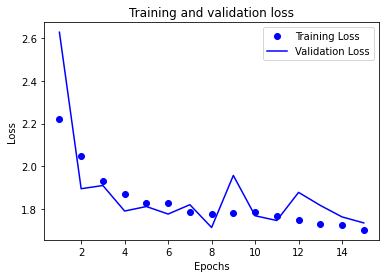

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['accuracy']) + 1)
plot_train_val_loss(history_dict, epochs)

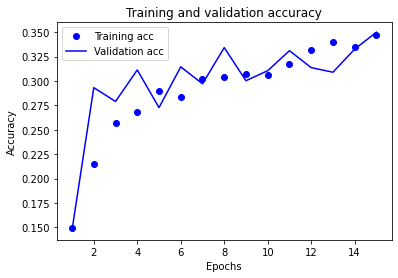

In [ ]:
plot_train_val_acc(history_dict, epochs)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


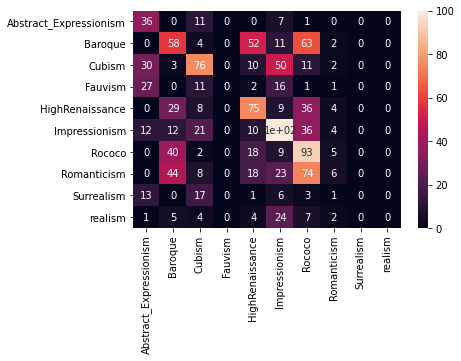

                        precision    recall  f1-score   support

Abstract_Expressionism       0.30      0.65      0.41        55
               Baroque       0.30      0.31      0.30       190
                Cubism       0.47      0.42      0.44       182
               Fauvism       0.00      0.00      0.00        58
       HighRenaissance       0.39      0.47      0.43       161
         Impressionism       0.39      0.51      0.44       195
                Rococo       0.29      0.56      0.38       167
           Romanticism       0.22      0.03      0.06       173
            Surrealism       0.00      0.00      0.00        41
               realism       0.00      0.00      0.00        47

              accuracy                           0.35      1269
             macro avg       0.24      0.29      0.25      1269
          weighted avg       0.30      0.35      0.31      1269



In [ ]:
confusion_matrix_report(model, test = validation_generator)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


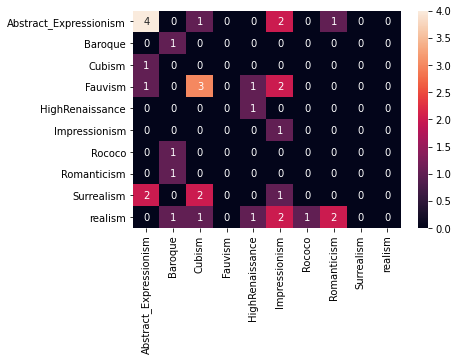

                        precision    recall  f1-score   support

Abstract_Expressionism       0.50      0.50      0.50         8
               Baroque       0.25      1.00      0.40         1
                Cubism       0.00      0.00      0.00         1
               Fauvism       0.00      0.00      0.00         7
       HighRenaissance       0.33      1.00      0.50         1
         Impressionism       0.12      1.00      0.22         1
                Rococo       0.00      0.00      0.00         1
           Romanticism       0.00      0.00      0.00         1
            Surrealism       0.00      0.00      0.00         5
               realism       0.00      0.00      0.00         8

              accuracy                           0.21        34
             macro avg       0.12      0.35      0.16        34
          weighted avg       0.14      0.21      0.15        34



In [ ]:
confusion_matrix_report(model)

# Model 5



In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(96, (3,3), activation = 'relu',
                       input_shape= (256, 256, 3)))
model.add(layers.Conv2D(96, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(192, (3,3), activation = 'relu'))
model.add(layers.Conv2D(192, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(384, (3,3), activation = 'relu'))
model.add(layers.Conv2D(384, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
# model.add(layers.Conv2D(384, (3,3), activation = 'relu'))
# model.add(layers.Conv2D(384, (3,3), activation = 'relu'))
# model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.2))

model.add(layers.Dense(1024, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1024, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1024, activation = 'relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(10, activation = 'softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 96)      2688      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 252, 252, 96)      83040     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 126, 126, 96)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 124, 124, 192)     166080    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 122, 122, 192)     331968    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 61, 61, 192)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 59, 59, 384)      

In [ ]:
opti = keras.optimizers.RMSprop(momentum=0.1) 
loss = 'categorical_crossentropy' #keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
metr = ['accuracy']

model.compile(optimizer = opti, 
              loss = loss, 
              metrics = metr)

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss',
                              patience = patience)

history = model.fit( 
            train_generator,
            epochs = 100,
            validation_data = validation_generator,
            # verbose = False,
            callbacks = [early_stopping]
            )
model.save('drive/MyDrive/models/cnn_model5.h5')

Epoch 1/100
167/167 [==============================] - 144s 856ms/step - loss: 2.2763 - accuracy: 0.1306 - val_loss: 2.0530 - val_accuracy: 0.2214
Epoch 2/100
167/167 [==============================] - 136s 812ms/step - loss: 2.1440 - accuracy: 0.1887 - val_loss: 1.9382 - val_accuracy: 0.2277
Epoch 3/100
167/167 [==============================] - 137s 817ms/step - loss: 1.9521 - accuracy: 0.2573 - val_loss: 1.9009 - val_accuracy: 0.2695
Epoch 4/100
167/167 [==============================] - 136s 815ms/step - loss: 1.8921 - accuracy: 0.2751 - val_loss: 1.7854 - val_accuracy: 0.2924
Epoch 5/100
167/167 [==============================] - 137s 819ms/step - loss: 1.8389 - accuracy: 0.3018 - val_loss: 1.8042 - val_accuracy: 0.3105
Epoch 6/100
167/167 [==============================] - 137s 819ms/step - loss: 1.8258 - accuracy: 0.2948 - val_loss: 1.7482 - val_accuracy: 0.3176
Epoch 7/100
167/167 [==============================] - 136s 816ms/step - loss: 1.7854 - accuracy: 0.3126 - val_loss: 1

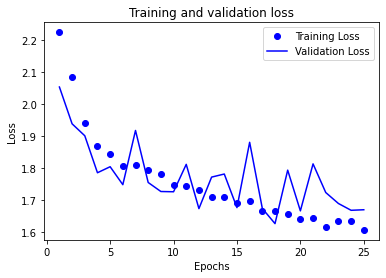

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['accuracy']) + 1)
plot_train_val_loss(history_dict, epochs)

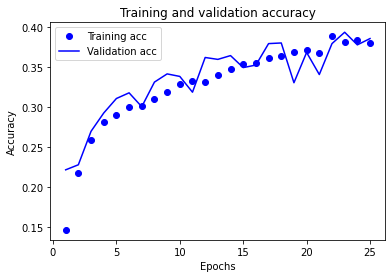

In [ ]:
plot_train_val_acc(history_dict, epochs)

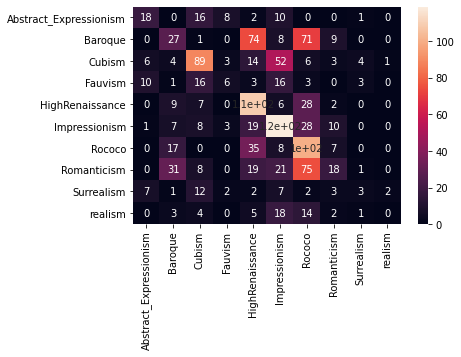

                        precision    recall  f1-score   support

Abstract_Expressionism       0.43      0.33      0.37        55
               Baroque       0.27      0.14      0.19       190
                Cubism       0.55      0.49      0.52       182
               Fauvism       0.27      0.10      0.15        58
       HighRenaissance       0.39      0.68      0.49       161
         Impressionism       0.45      0.61      0.52       195
                Rococo       0.31      0.60      0.40       167
           Romanticism       0.33      0.10      0.16       173
            Surrealism       0.23      0.07      0.11        41
               realism       0.00      0.00      0.00        47

              accuracy                           0.39      1269
             macro avg       0.32      0.31      0.29      1269
          weighted avg       0.36      0.39      0.35      1269



In [ ]:
confusion_matrix_report(model, test = validation_generator)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


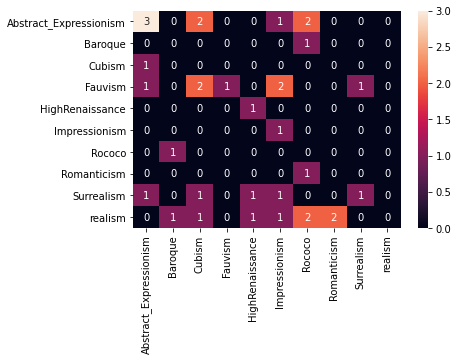

                        precision    recall  f1-score   support

Abstract_Expressionism       0.50      0.38      0.43         8
               Baroque       0.00      0.00      0.00         1
                Cubism       0.00      0.00      0.00         1
               Fauvism       1.00      0.14      0.25         7
       HighRenaissance       0.33      1.00      0.50         1
         Impressionism       0.17      1.00      0.29         1
                Rococo       0.00      0.00      0.00         1
           Romanticism       0.00      0.00      0.00         1
            Surrealism       0.50      0.20      0.29         5
               realism       0.00      0.00      0.00         8

              accuracy                           0.21        34
             macro avg       0.25      0.27      0.18        34
          weighted avg       0.41      0.21      0.22        34



In [ ]:
confusion_matrix_report(model)

# RESNET



In [ ]:
from keras.applications import ResNet50

model = models.Sequential()

model.add(ResNet50(weights = 'imagenet', include_top = False, input_shape = (size, size, 3)))

model.add(layers.Flatten())

model.add(layers.Dense(1024, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1024, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1024, activation = 'relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(10, activation = 'softmax'))

model.layers[0].trainable = False

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              134218752 
_________________________________________________________________
dropout_11 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 1024)             

In [ ]:
opti = keras.optimizers.RMSprop(momentum=0.1) 
loss = 'categorical_crossentropy' #keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
metr = ['accuracy']

model.compile(optimizer = opti, 
              loss = loss, 
              metrics = metr)

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss',
                              patience = patience)

history = model.fit( 
            train_generator,
            epochs = 100,
            validation_data = validation_generator,
            # verbose = False,
            callbacks = [early_stopping]
            )

Epoch 1/100
167/167 [==============================] - 170s 976ms/step - loss: 26.4462 - accuracy: 0.1299 - val_loss: 2.1699 - val_accuracy: 0.1497
Epoch 2/100
167/167 [==============================] - 123s 738ms/step - loss: 2.2614 - accuracy: 0.1420 - val_loss: 2.1928 - val_accuracy: 0.1324
Epoch 3/100
167/167 [==============================] - 123s 737ms/step - loss: 2.2380 - accuracy: 0.1412 - val_loss: 2.1652 - val_accuracy: 0.1316
Epoch 4/100
167/167 [==============================] - 121s 726ms/step - loss: 2.2290 - accuracy: 0.1404 - val_loss: 2.1664 - val_accuracy: 0.1434
Epoch 5/100
167/167 [==============================] - 122s 730ms/step - loss: 2.2058 - accuracy: 0.1402 - val_loss: 2.1762 - val_accuracy: 0.1505
Epoch 6/100
167/167 [==============================] - 124s 738ms/step - loss: 2.1977 - accuracy: 0.1422 - val_loss: 2.1667 - val_accuracy: 0.1434
Epoch 7/100
167/167 [==============================] - 125s 744ms/step - loss: 2.1991 - accuracy: 0.1430 - val_loss: 

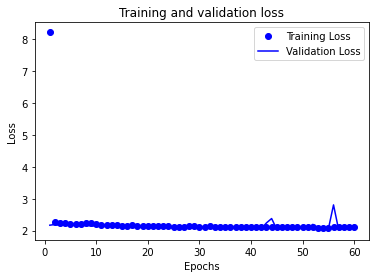

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['accuracy']) + 1)
plot_train_val_loss(history_dict, epochs)

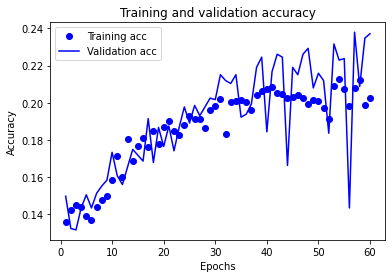

In [ ]:
plot_train_val_acc(history_dict, epochs)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


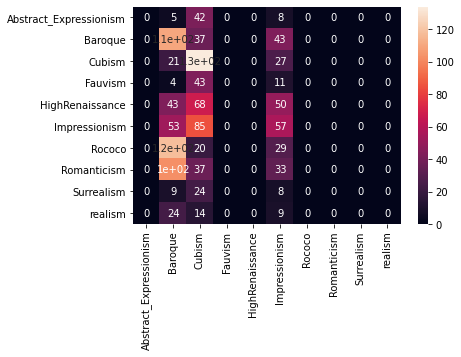

                        precision    recall  f1-score   support

Abstract_Expressionism       0.00      0.00      0.00        55
               Baroque       0.22      0.58      0.32       190
                Cubism       0.27      0.74      0.39       182
               Fauvism       0.00      0.00      0.00        58
       HighRenaissance       0.00      0.00      0.00       161
         Impressionism       0.21      0.29      0.24       195
                Rococo       0.00      0.00      0.00       167
           Romanticism       0.00      0.00      0.00       173
            Surrealism       0.00      0.00      0.00        41
               realism       0.00      0.00      0.00        47

              accuracy                           0.24      1269
             macro avg       0.07      0.16      0.10      1269
          weighted avg       0.10      0.24      0.14      1269



In [ ]:
confusion_matrix_report(model, test = validation_generator)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


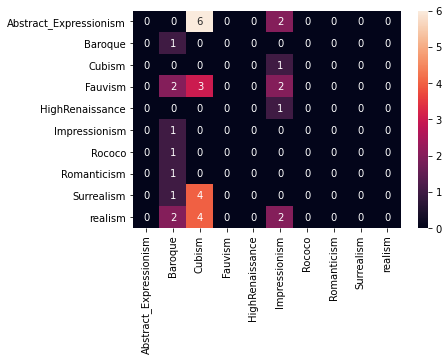

                        precision    recall  f1-score   support

Abstract_Expressionism       0.00      0.00      0.00         8
               Baroque       0.11      1.00      0.20         1
                Cubism       0.00      0.00      0.00         1
               Fauvism       0.00      0.00      0.00         7
       HighRenaissance       0.00      0.00      0.00         1
         Impressionism       0.00      0.00      0.00         1
                Rococo       0.00      0.00      0.00         1
           Romanticism       0.00      0.00      0.00         1
            Surrealism       0.00      0.00      0.00         5
               realism       0.00      0.00      0.00         8

              accuracy                           0.03        34
             macro avg       0.01      0.10      0.02        34
          weighted avg       0.00      0.03      0.01        34



In [ ]:
confusion_matrix_report(model)

# Model 6



In [14]:
model = models.Sequential()

model = models.Sequential()

model.add(layers.Conv2D(48, (3,3), activation = 'relu',
                       input_shape= (256, 256, 3)))
model.add(layers.Conv2D(48, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(96, (3,3), activation = 'relu'))
model.add(layers.Conv2D(96, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(192, (3,3), activation = 'relu'))
model.add(layers.Conv2D(192, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(384, (3,3), activation = 'relu'))
model.add(layers.Conv2D(384, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.2))

model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(10, activation = 'softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 48)      1344      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 48)      20784     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 48)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 96)      41568     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 122, 122, 96)      83040     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 59, 59, 192)      

In [15]:
opti = keras.optimizers.RMSprop(momentum=0.1) 
loss = 'categorical_crossentropy' #keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
metr = ['accuracy']

model.compile(optimizer = opti, 
              loss = loss, 
              metrics = metr)

In [16]:
early_stopping = EarlyStopping(monitor = 'val_loss',
                              patience = patience)

history = model.fit( 
            train_generator,
            epochs = 100,
            validation_data = validation_generator,
            # verbose = False
            callbacks = [early_stopping]
            )
model.save('drive/MyDrive/models/cnn_model6.h5')

Epoch 1/100
167/167 [==============================] - 1448s 8s/step - loss: 6.1161 - accuracy: 0.1464 - val_loss: 2.1943 - val_accuracy: 0.1828
Epoch 2/100
167/167 [==============================] - 128s 767ms/step - loss: 2.1663 - accuracy: 0.1989 - val_loss: 2.0716 - val_accuracy: 0.2183
Epoch 3/100
167/167 [==============================] - 127s 759ms/step - loss: 1.9953 - accuracy: 0.2435 - val_loss: 1.8572 - val_accuracy: 0.2340
Epoch 4/100
167/167 [==============================] - 127s 757ms/step - loss: 1.8899 - accuracy: 0.2748 - val_loss: 1.8194 - val_accuracy: 0.3026
Epoch 5/100
167/167 [==============================] - 127s 760ms/step - loss: 1.8336 - accuracy: 0.2873 - val_loss: 1.9622 - val_accuracy: 0.2569
Epoch 6/100
167/167 [==============================] - 127s 759ms/step - loss: 1.8370 - accuracy: 0.2999 - val_loss: 1.7381 - val_accuracy: 0.3349
Epoch 7/100
167/167 [==============================] - 127s 758ms/step - loss: 1.8099 - accuracy: 0.3065 - val_loss: 1.7

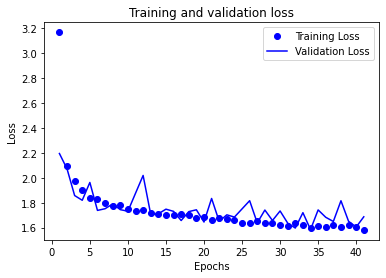

In [17]:
history_dict = history.history
epochs = range(1, len(history_dict['accuracy']) + 1)
plot_train_val_loss(history_dict, epochs)

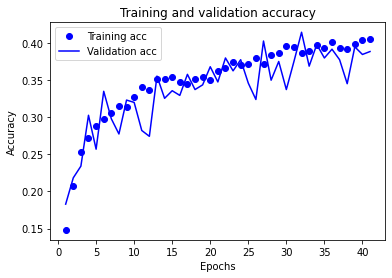

In [18]:
plot_train_val_acc(history_dict, epochs)

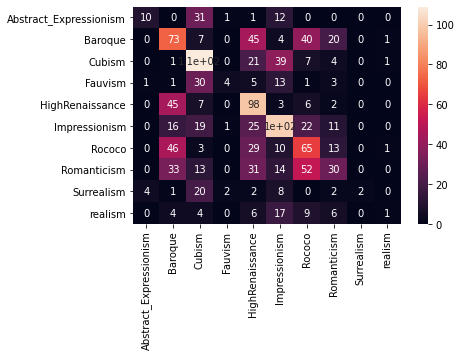

                        precision    recall  f1-score   support

Abstract_Expressionism       0.67      0.18      0.29        55
               Baroque       0.33      0.38      0.36       190
                Cubism       0.45      0.60      0.51       182
               Fauvism       0.50      0.07      0.12        58
       HighRenaissance       0.37      0.61      0.46       161
         Impressionism       0.46      0.52      0.49       195
                Rococo       0.32      0.39      0.35       167
           Romanticism       0.33      0.17      0.23       173
            Surrealism       1.00      0.05      0.09        41
               realism       0.25      0.02      0.04        47

              accuracy                           0.39      1269
             macro avg       0.47      0.30      0.29      1269
          weighted avg       0.41      0.39      0.36      1269



In [19]:
confusion_matrix_report(model, test = validation_generator)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


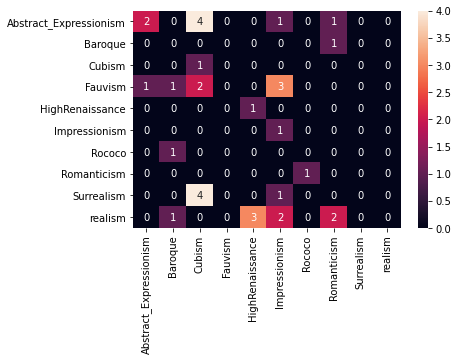

                        precision    recall  f1-score   support

Abstract_Expressionism       0.67      0.25      0.36         8
               Baroque       0.00      0.00      0.00         1
                Cubism       0.09      1.00      0.17         1
               Fauvism       0.00      0.00      0.00         7
       HighRenaissance       0.25      1.00      0.40         1
         Impressionism       0.12      1.00      0.22         1
                Rococo       0.00      0.00      0.00         1
           Romanticism       0.00      0.00      0.00         1
            Surrealism       0.00      0.00      0.00         5
               realism       0.00      0.00      0.00         8

              accuracy                           0.15        34
             macro avg       0.11      0.33      0.12        34
          weighted avg       0.17      0.15      0.11        34



In [20]:
confusion_matrix_report(model)

# Model 7

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 8)

history = model.fit(train_generator, epochs=50,
                              validation_data=validation_generator,
                            callbacks=[early_stopping])model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 8)

history = model.fit(train_generator, epochs=50,
                              validation_data=validation_generator,
                            callbacks=[early_stopping])

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['accuracy']) + 1)
plot_train_val_loss(history_dict, epochs)

In [ ]:
plot_train_val_acc(history_dict, epochs)

# VGG19



In [21]:
from keras.applications import VGG19

model = models.Sequential()

model.add(VGG19(weights = 'imagenet', include_top = False, input_shape = (size, size, 3)))

model.add(layers.Flatten())

model.add(layers.Dense(1024, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1024, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1024, activation = 'relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(10, activation = 'softmax'))

model.layers[0].trainable = False

model.summary()

80142336/80134624 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              33555456  
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_______________________________________________________

In [22]:
opti = keras.optimizers.RMSprop(momentum=0.1) 
loss = 'categorical_crossentropy' #keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
metr = ['accuracy']

model.compile(optimizer = opti, 
              loss = loss, 
              metrics = metr)

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss',
                              patience = patience)

history = model.fit( 
            train_generator,
            epochs = 100,
            validation_data = validation_generator,
            # verbose = False,
            callbacks = [early_stopping]
            )

Epoch 1/100
161/167 [===========================>..] - ETA: 3s - loss: 7.7571 - accuracy: 0.1670

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['accuracy']) + 1)
plot_train_val_loss(history_dict, epochs)

In [ ]:
plot_train_val_acc(history_dict, epochs)

In [ ]:
confusion_matrix_report(model, test = validation_generator)

In [ ]:
confusion_matrix_report(model)